In [129]:
import os
import json
import numpy as np

from vae import Sampling, VAE

from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets.fashion_mnist import load_data

import matplotlib.pyplot as plt

In [8]:
(x_train, _), (x_test, _) = load_data()

In [9]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [62]:
latent_dim = 16

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [63]:
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')
vae.load_weights('./results/model_03/vae_weights')

<IPython.core.display.Javascript object>


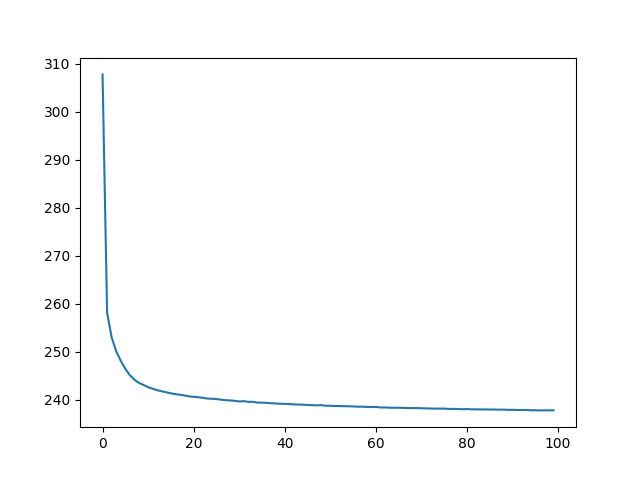

In [64]:
with open('./results/model_03/training_history.json', 'r') as f:
    history = json.load(f)
    
plt.plot(history['loss'])
# plt.plot(history['val_loss'])
plt.show()

In [65]:
z_mean_train, _, _ = vae.encoder(x_train)
z_mean_test, _, _ = vae.encoder(x_test)

In [66]:
# clf = LocalOutlierFactor(n_neighbors=20, novelty=False)
# clf = OneClassSVM(degree=3)
# clf = IsolationForest(n_estimators=100)
# clf = EllipticEnvelope()

In [138]:
kde = KernelDensity(bandwidth=0.00001, kernel='cosine')
gm = GaussianMixture(n_components=20)

In [139]:
kde.fit(z_mean_train)

KernelDensity(bandwidth=1e-05, kernel='cosine')

In [140]:
gm.fit(z_mean_train)

GaussianMixture(n_components=20)

In [127]:
anomaly_scores = -1 * kde.score_samples(z_mean_test)

In [141]:
anomaly_scores = -1 * gm.score_samples(z_mean_test)

In [104]:
anomaly_scores = np.exp(anomaly_scores)

In [67]:
clf.fit(z_mean_train)

LocalOutlierFactor(novelty=True)

In [117]:
anomaly_scores = -1 * clf.decision_function(z_mean_test)

KeyboardInterrupt: 

In [142]:
prioritization = np.argsort(anomaly_scores)[::-1]

np.save('./tmp/vae_bottleneck.npy', prioritization)

In [71]:
pca = PCA(n_components=2)
tsne = TSNE(n_components=2)

In [72]:
pca_train = pca.fit_transform(z_mean_train)
pca_test = pca.transform(z_mean_test)

/Users/vmosin/.virtualenvs/tensorflow/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/vmosin/.virtualenvs/tensorflow/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


AttributeError: 'TSNE' object has no attribute 'transform'

In [60]:
%matplotlib notebook

<IPython.core.display.Javascript object>


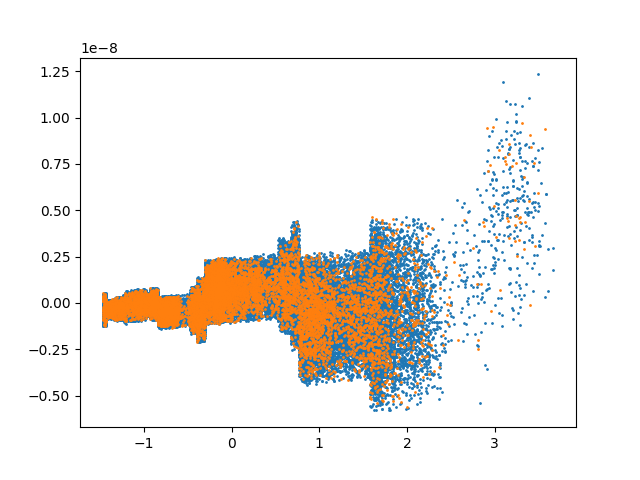

In [61]:
plt.scatter(pca_train[:,0], pca_train[:,1], s=1)
plt.scatter(pca_test[:,0], pca_test[:,1], s=1)
plt.show()

In [ ]:
plt.scatter(tsne_train[:,0], tsne_train[:,1], s=1)
plt.scatter(tsne_test[:,0], tsne_test[:,1], s=1)
plt.show()